In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import seaborn as sns
import datetime, tqdm
import os
import matplotlib.patches as patches
pd.set_option('max_columns', 100)
#from kaggle.competitions import nflrush
from sklearn.model_selection import KFold, RepeatedKFold
import math
import scipy
import numpy as np
import pandas as pd
import sklearn.metrics as mtr
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Dropout, PReLU, BatchNormalization, ELU, GaussianNoise, Activation
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import Callback, EarlyStopping
import gc
import os
from tqdm import tqdm_notebook
#note： 
#1. As a result it might not be worthwhile to use features related to game clock/quarter of the game。
#2. There is no relationships between number of rushes before and running yards gained。
#3. rushing success larger depends on defender in box, or defender that are close to offensive lineman and attempt 
#   to counter the blocking.
#4. highly drafted player has the same average rushing yards as the rest
#ARI: Arizona Cardinals
#ATL: Atlanta Falcons
#BAL: Baltimore Ravens
#BUF: Buffalo Bills
#CAR: Carolina Panthers
#CHI: Chicago Bears
#CIN: Cincinnati Bengals
#CLE: Cleveland Browns
#DAL: Dallas Cowboys
#DEN: Denver Broncos
#DET: Detroit Lions
#GB: Green Bay Packers
#HOU: Houston Texans
#IND: Indianapolis Colts
#JAX: Jacksonville Jaguars
#KC: Kansas City Chiefs
#MIA: Miami Dolphins
#MIN: Minnesota Vikings
#NE: New England Patriots
#NO: New Orleans Saints
#NYG: New York Giants
#NYJ: New York Jets
#OAK: Oakland Raiders
#PHI: Philadelphia Eagles
#PIT: Pittsburgh Steelers
#SD: San Diego Chargers
#SEA: Seattle Seahawks
#SF: San Francisco 49ers
#STL: Saint Louis Rams
#TB: Tampa Bay Buccaneers
#TEN Tennessee Titans
#WAS: Washington Redskins

In [54]:
train_df = pd.read_csv(r'\\Neptune\RiskMgmtArchive\3 Temp Hold\Temp_Jason\research\train.csv')

C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
#team abbreviations correct
def data_clean(df):
#correct name   
    df.loc[df['PossessionTeam'] == 'ARZ', 'PossessionTeam'] = 'ARI'
    df.loc[df['PossessionTeam'] == 'BLT', 'PossessionTeam'] = 'BAL'
    df.loc[df['PossessionTeam'] == 'CLV', 'PossessionTeam'] = 'CLE'
    df.loc[df['PossessionTeam'] == 'HST', 'PossessionTeam'] = 'HOU'
    df.loc[df['FieldPosition'] == 'ARZ', 'FieldPosition'] = 'ARI'
    df.loc[df['FieldPosition'] == 'BLT', 'FieldPosition'] = 'BAL'
    df.loc[df['FieldPosition'] == 'CLV', 'FieldPosition'] = 'CLE'
    df.loc[df['FieldPosition'] == 'HST', 'FieldPosition'] = 'HOU'

# fill null
    df = df.fillna(df.median())

# offense time and defence time
    df['TeamOnOffense'] = "home"
    df.loc[df.PossessionTeam != df.HomeTeamAbbr, 'TeamOnOffense'] = "away"
    df['IsOnOffense'] = df.Team == df.TeamOnOffense # Is player on offense?
    
#time
    df['TimeHandoff'] = df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    df['TimeSnap'] = df['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    df['PlayerBirthDate'] = df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
    seconds_in_year = 60*60*24*365.25
    df['PlayerAge'] = df.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
    df['GameClock'] = df['GameClock'].apply(lambda x: float(x.split(":")[0]) + float(x.split(":")[1])/60)
    df['TimeDelta'] = df.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
#player height
    df['PlayerHeight'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

#weather
    def map_weather(txt):
        ans = 1
        if pd.isna(txt):
            return 0
        if 'partly' in txt:
            ans*=0.5
        if 'climate controlled' in txt or 'indoor' in txt:
            return ans*3
        if 'sunny' in txt or 'sun' in txt:
            return ans*2
        if 'clear' in txt:
            return ans
        if 'cloudy' in txt:
            return -ans
        if 'rain' in txt or 'rainy' in txt:
            return -2*ans
        if 'snow' in txt:
            return -3*ans
        return 0
    df['Cleaned_GameWeather'] = df['GameWeather'].str.lower()
    indoor = "indoor"
    df['Cleaned_GameWeather'] = df['GameWeather'].apply(lambda x: indoor if not pd.isna(x) and indoor in x else x)
    df['Cleaned_GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
    df['Cleaned_GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
    df['Cleaned_GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
    df['Cleaned_GameWeather'] = df['Cleaned_GameWeather'].apply(map_weather)

#diff Score    
    df["DiffScoreBeforePlay_ob"] = (df["HomeScoreBeforePlay"] - df["VisitorScoreBeforePlay"])
    df.loc[df['Team'] == 'away',["DiffScoreBeforePlay_ob"]] = - df.loc[df['Team'] == 'away',["DiffScoreBeforePlay_ob"]]
#Turf
    Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 
    df['Cleaned_Turf'] = df['Turf'].map(Turf)

#left to right
    df['New_X'] = df['X']
    df.loc[df['PlayDirection'] == 'left','New_X'] = 120 - df.loc[df['PlayDirection'] == 'left','X']
    df['New_Y'] = df['Y']
    df.loc[df['PlayDirection'] == 'left','New_Y'] = 160/3 - df.loc[df['PlayDirection'] == 'left','Y']
    df['Orientation_std'] = df['Orientation']
    df.loc[df['Season'] == 2017, 'Orientation_std'] = df.loc[df['Season'] == 2017, 'Orientation_std'] + 90
    df.loc[(df['Season'] > 2017)&(df['PlayDirection'] == 'left'), 'Orientation_std'] = 360 - df.loc[(df['Season'] > 2017)&(df['PlayDirection'] == 'left'), 'Orientation_std']
    df.loc[df['PlayDirection'] == 'left', 'Orientation_std'] = np.mod(180 + df.loc[df['PlayDirection'] == 'left', 'Orientation_std'], 360)
    df['Dir_std'] = df['Dir']
    df.loc[df['PlayDirection'] == 'left', 'Dir_std'] = 360 - df.loc[df['PlayDirection'] == 'left', 'Dir_std']
    df.loc[df['PlayDirection'] == 'left', 'Dir_std'] = np.mod(180 + df.loc[df['PlayDirection'] == 'left', 'Dir_std'], 360)
    df['YardLine_std'] = 100 - df['YardLine']
    df.loc[df.FieldPosition.fillna('') == df.PossessionTeam,  
          'YardLine_std'
         ] = df.loc[df.FieldPosition.fillna('') == df.PossessionTeam,  
          'YardLine']
    df["Orientation_sin"] = df["Orientation_std"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
    df["Orientation_cos"] = df["Orientation_std"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
    df["Dir_sin"] = df["Dir_std"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
    df["Dir_cos"] = df["Dir_std"].apply(lambda x : np.cos(x/360 * 2 * np.pi))

#distance
    #distance to yardline
    df['Dis_YardLine'] = df['New_X'] - df['YardLine_std'] - 10
    #distance to rusher
    def Distance(x1,x2,y1,y2):
        x_diff = (x1-x2)**2
        y_diff = (y1-y2)**2
        return np.sqrt(x_diff + y_diff)
    def Degree(x1,x2,y1,y2):
        try:
            tan = (y1-y2)/(x1-x2)
        except:
            tan = 0
        degree = 90 - math.atan(tan)/(2*np.pi)*360
        return degree
    df['IsRusher'] = (df['NflId'] == df['NflIdRusher'])
    Rusher =df.loc[df['IsRusher'],['PlayId','X','Y','Dir_std']].rename(columns={"X":"Rusher_X","Y":"Rusher_Y",'PossessionTeam':'Offense_Team','Dir_std':'Rusher_Dir_std'})
    df = df.merge(Rusher,how = 'left',on = 'PlayId')
    df['Distance_to_Rusher'] = df[["X","Rusher_X","Y","Rusher_Y"]].apply(lambda x: Distance(x[0],x[1],x[2],x[3]), axis = 1)
    df['Degree_to_Rusher'] = df[["X","Rusher_X","Y","Rusher_Y"]].apply(lambda x: Degree(x[0],x[1],x[2],x[3]), axis = 1)
    df['Degree_Diff'] = abs(df['Degree_to_Rusher'] - df['Rusher_Dir_std'])
    #back_direction
    def back_direction(orientation):
        if orientation > 180.0:
            return 1
        else:
            return 0
    df['back_oriented_down_field'] = df['Orientation_std'].apply(lambda x: back_direction(x))

# Stadium clean
    map_stad = {'Broncos Stadium at Mile High': 'Broncos Stadium At Mile High', 'CenturyField': 'CenturyLink Field', 'CenturyLink': 'CenturyLink Field', 'Everbank Field': 'EverBank Field', 'FirstEnergy': 'First Energy Stadium', 'FirstEnergy Stadium': 'First Energy Stadium', 'FirstEnergyStadium': 'First Energy Stadium', 'Lambeau field': 'Lambeau Field', 'Los Angeles Memorial Coliesum': 'Los Angeles Memorial Coliseum', 'M & T Bank Stadium': 'M&T Bank Stadium', 'M&T Stadium': 'M&T Bank Stadium', 'Mercedes-Benz Dome': 'Mercedes-Benz Superdome', 'MetLife': 'MetLife Stadium', 'Metlife Stadium': 'MetLife Stadium', 'NRG': 'NRG Stadium', 'Oakland Alameda-County Coliseum': 'Oakland-Alameda County Coliseum', 'Paul Brown Stdium': 'Paul Brown Stadium', 'Twickenham': 'Twickenham Stadium'}
    
    for stad in df['Stadium'].unique():
        if stad in map_stad.keys():
            pass
        else:
            map_stad[stad]=stad

    df['Stadium'] = df['Stadium'].map(map_stad)

# wind 
    def give_me_WindSpeed(x):
            x = str(x)
            x = x.replace('mph', '').strip()
            if '-' in x:
                x = (int(x.split('-')[0]) + int(x.split('-')[1])) / 2
            elif 'gusts up to' in x:
                x = (int(x.split()[0]) + int(x.split()[-1])) / 2
            elif 'clam' in x:
                x = 0
            try:
                return float(x)
            except:
                return -99
    df['Cleaned_WindSpeed'] = df['WindSpeed'].apply(give_me_WindSpeed)

    
# speed
    df['Horizontal Speed'] = df['S']*df["Dir_sin"]
    df['Vertical Speed'] = df['S']*df["Dir_cos"]

    
    return df

In [56]:
train = data_clean(train_df)

C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in double_scalars


In [58]:
def split_data(df):
    df1 = df.loc[df['IsRusher']]
    df2 = df.loc[df['IsOnOffense'] & (~df['IsRusher'])]
    df3 = df.loc[~df['IsOnOffense']]

# handoff times
    df1 = df1.sort_values(['GameId','PlayId','Quarter','GameClock'])
    df1['# of Handoff Play'] = 1
    df1['# of Handoff Play'] = df1[['GameId','PlayId','# of Handoff Play']].groupby(['GameId','PlayId']).cumsum()
# min_time_to_tacke
    df3['Min_Time_Tacke'] = df3['Distance_to_Rusher']/df3['S']
    df3.loc[df3['Min_Time_Tacke'] == np.inf, 'Min_Time_Tacke'] = 20
# defence_X_Y_spread
    Defence_X_Y_std = df3[["PlayId",'New_X','New_Y']].groupby("PlayId").std().rename(columns={'New_X':'Defense_X_std','New_Y':'Defense_Y_std'}) \
    .reset_index()
    
    df3 = df3.sort_values(['PlayId','New_X'])
    Defense_X_Removed2_std = df3[["PlayId",'New_X']].drop(np.hstack([df3.groupby('PlayId').tail(1).index, df3.groupby('PlayId').head(1).index]))\
    .groupby('PlayId').std().rename(columns={'New_X':'Defense_X_Removed2_std'}).reset_index()

    df3 = df3.sort_values(['PlayId','New_Y'])
    Defense_Y_Removed2_std = df3[["PlayId",'New_Y']].drop(np.hstack([df3.groupby('PlayId').tail(1).index, df3.groupby('PlayId').head(1).index]))\
    .groupby('PlayId').std().rename(columns={'New_Y':'Defense_Y_Removed2_std'}).reset_index()
    
    df3 = df3.sort_values(['PlayId','New_X'])
    Defense_X_Removed4_std = df3[["PlayId",'New_X']].drop(np.hstack([df3.groupby('PlayId').tail(2).index, df3.groupby('PlayId').head(2).index]))\
    .groupby('PlayId').std().rename(columns={'New_X':'Defense_X_Removed4_std'}).reset_index()
    
    df3 = df3.sort_values(['PlayId','New_Y'])
    Defense_Y_Removed4_std = df3[["PlayId",'New_Y']].drop(np.hstack([df3.groupby('PlayId').tail(2).index, df3.groupby('PlayId').head(2).index]))\
    .groupby('PlayId').std().rename(columns={'New_Y':'Defense_Y_Removed4_std'}).reset_index()
    df1 = df1.merge(Defence_X_Y_std, how = 'left',  on ='PlayId')
    df1 = df1.merge(Defense_X_Removed2_std,how = 'left',  on ='PlayId')
    df1 = df1.merge(Defense_Y_Removed2_std,how = 'left',  on ='PlayId')
    df1 = df1.merge(Defense_X_Removed4_std,how = 'left',  on ='PlayId')
    df1 = df1.merge(Defense_Y_Removed4_std,how = 'left',  on ='PlayId')

# offense_X_Y_spread
    df2 = df2.sort_values(['PlayId','New_X'])
    Offense_X_Removed2_std = df2[["PlayId",'New_X']].drop(np.hstack([df2.groupby('PlayId').tail(1).index, df2.groupby('PlayId').head(1).index])) \
    .groupby('PlayId').std().rename(columns={'New_X':'Offense_X_Removed2_std'}).reset_index()
    df2 = df2.sort_values(['PlayId','New_Y'])
    Offense_Y_Removed2_std = df2[["PlayId",'New_Y']].drop(np.hstack([df2.groupby('PlayId').tail(1).index, df2.groupby('PlayId').head(1).index]))\
    .groupby('PlayId').std().rename(columns={'New_Y':'Offense_Y_Removed2_std'}).reset_index()
    
    df2 = df2.sort_values(['PlayId','New_Y'])
    Offense_X_Removed4_std = df2[["PlayId",'New_X']].drop(np.hstack([df2.groupby('PlayId').tail(2).index, df2.groupby('PlayId').head(2).index])) \
    .groupby('PlayId').std().rename(columns={'New_X':'Offense_X_Removed4_std'}).reset_index()
    df2 = df2.sort_values(['PlayId','New_Y'])
    Offense_Y_Removed4_std = df2[["PlayId",'New_Y']].drop(np.hstack([df2.groupby('PlayId').tail(2).index, df2.groupby('PlayId').head(2).index])) \
    .groupby('PlayId').std().rename(columns={'New_Y':'Offense_Y_Removed4_std'}).reset_index()
    df1 = df1.merge(Offense_X_Removed2_std,how = 'left',  on ='PlayId')
    df1 = df1.merge(Offense_Y_Removed2_std,how = 'left',  on ='PlayId')
    df1 = df1.merge(Offense_X_Removed4_std,how = 'left',  on ='PlayId')
    df1 = df1.merge(Offense_Y_Removed4_std,how = 'left',  on ='PlayId')
    
# nearest offenders to defender
    dis_to_closest_offender = pd.DataFrame()
    for playid in df3['PlayId'].unique():
        offense = df2.loc[df2['PlayId'] == playid]
        defence = df3.loc[df3['PlayId'] == playid]
        ary = scipy.spatial.distance.cdist(defence[['New_X','New_Y']], offense[['New_X','New_Y']], metric='euclidean')
        ary.sort(axis=1)
        ary = pd.DataFrame(data = ary)
        ary['PlayId'] = playid
        ary.reset_index(drop=True, inplace=True)
        ary = pd.concat([ary, defence[['NflId']].reset_index(drop=True)], axis=1)
        dis_to_closest_offender = dis_to_closest_offender.append(ary)
    df3 = df3.merge(dis_to_closest_offender,how = 'left',on = ['PlayId','NflId'])

# personnel_features
    def defense_formation(l):
        dl = 0
        lb = 0
        db = 0
        other = 0

        for position in l:
            sub_string = position.split(' ')
            if sub_string[1] == 'DL':
                dl += int(sub_string[0])
            elif sub_string[1] in ['LB','OL']:
                lb += int(sub_string[0])
            else:
                db += int(sub_string[0])

        counts = (dl,lb,db,other)

        return counts
    def offense_formation(l):
        qb = 0
        rb = 0
        wr = 0
        te = 0
        ol = 0

        sub_total = 0
        qb_listed = False
        for position in l:
            sub_string = position.split(' ')
            pos = sub_string[1]
            cnt = int(sub_string[0])

            if pos == 'QB':
                qb += cnt
                sub_total += cnt
                qb_listed = True
            # Assuming LB is a line backer lined up as full back
            elif pos in ['RB','LB']:
                rb += cnt
                sub_total += cnt
            # Assuming DB is a defensive back and lined up as WR
            elif pos in ['WR','DB']:
                wr += cnt
                sub_total += cnt
            elif pos == 'TE':
                te += cnt
                sub_total += cnt
            # Assuming DL is a defensive lineman lined up as an additional line man
            else:
                ol += cnt
                sub_total += cnt

        # If not all 11 players were noted at given positions we need to make some assumptions
        # I will assume if a QB is not listed then there was 1 QB on the play
        # If a QB is listed then I'm going to assume the rest of the positions are at OL
        # This might be flawed but it looks like RB, TE and WR are always listed in the personnel
        if sub_total < 11:
            diff = 11 - sub_total
            if not qb_listed:
                qb += 1
                diff -= 1
            ol += diff

        counts = (qb,rb,wr,te,ol)

        return counts
    def split_personnel(s):
        splits = s.split(',')
        for i in range(len(splits)):
            splits[i] = splits[i].strip()

        return splits    
    def personnel_features(df):
        personnel = df[['GameId','PlayId','OffensePersonnel','DefensePersonnel']].drop_duplicates()
        personnel['DefensePersonnel'] = personnel['DefensePersonnel'].apply(lambda x: split_personnel(x))
        personnel['DefensePersonnel'] = personnel['DefensePersonnel'].apply(lambda x: defense_formation(x))
        personnel['num_DL'] = personnel['DefensePersonnel'].apply(lambda x: x[0])
        personnel['num_LB'] = personnel['DefensePersonnel'].apply(lambda x: x[1])
        personnel['num_DB'] = personnel['DefensePersonnel'].apply(lambda x: x[2])

        personnel['OffensePersonnel'] = personnel['OffensePersonnel'].apply(lambda x: split_personnel(x))
        personnel['OffensePersonnel'] = personnel['OffensePersonnel'].apply(lambda x: offense_formation(x))
        personnel['num_QB'] = personnel['OffensePersonnel'].apply(lambda x: x[0])
        personnel['num_RB'] = personnel['OffensePersonnel'].apply(lambda x: x[1])
        personnel['num_WR'] = personnel['OffensePersonnel'].apply(lambda x: x[2])
        personnel['num_TE'] = personnel['OffensePersonnel'].apply(lambda x: x[3])
        personnel['num_OL'] = personnel['OffensePersonnel'].apply(lambda x: x[4])

        # Let's create some features to specify if the OL is covered
        personnel['OL_diff'] = personnel['num_OL'] - personnel['num_DL']
        personnel['OL_TE_diff'] = (personnel['num_OL'] + personnel['num_TE']) - personnel['num_DL']
        # Let's create a feature to specify if the defense is preventing the run
        # Let's just assume 7 or more DL and LB is run prevention
        personnel['run_def'] = (personnel['num_DL'] + personnel['num_LB'] > 6).astype(int)

        personnel.drop(['OffensePersonnel','DefensePersonnel'], axis=1, inplace=True)
        
        return personnel
    
    personnel = personnel_features(df1)   
    df1 = df1.merge(personnel,how = 'left',  on ='PlayId')
    
#select useful columns    
    rusher = df1[['PlayId','TimeDelta','Team','PlayerAge','PlayerHeight','PlayerWeight','New_X','New_Y', \
                 'Orientation_std','Dir_std','Dis_YardLine','Horizontal Speed','Vertical Speed','S','A','Dis','Position',\
                 '# of Handoff Play','Quarter','GameClock','Down','Distance','OffenseFormation',\
                  'DefendersInTheBox','HomeScoreBeforePlay','VisitorScoreBeforePlay',\
                 'Offense_X_Removed2_std','Offense_Y_Removed2_std','Offense_X_Removed4_std','Offense_Y_Removed4_std',\
                 'Defense_X_std','Defense_Y_std','Defense_X_Removed2_std','Offense_Y_Removed2_std','Defense_X_Removed4_std',\
                 'Defense_Y_Removed4_std',\
                  'num_DL','num_LB','num_DB','num_QB','num_RB','num_WR','num_TE','num_OL','OL_diff','OL_TE_diff','run_def'\
                 ]]
    rusher = rusher.sort_values('PlayId')
    game = df1[['PlayId','Cleaned_GameWeather','Humidity','Temperature', \
              'Week']]
    game = game.sort_values('PlayId')
    offender = df2[['PlayId','PlayerAge','PlayerHeight','PlayerWeight','New_X','New_Y','Orientation_std','Dir_std','back_oriented_down_field',\
                  'Horizontal Speed','Vertical Speed','S','A','Dis','Position','Distance_to_Rusher',\
                   'Degree_to_Rusher','Degree_Diff']]
    offender = offender.sort_values(['PlayId','New_Y'])
    defender = df3[['PlayId','PlayerAge','PlayerHeight','PlayerWeight','New_X','New_Y','Orientation_std','Dir_std','back_oriented_down_field',\
                  'Horizontal Speed','Vertical Speed','S','A','Dis','Position','Distance_to_Rusher',\
                   'Degree_to_Rusher','Degree_Diff','Min_Time_Tacke']+list(range(2))]
    defender = defender.sort_values(['PlayId','New_Y'])
    
    y = df1[['PlayId','Yards']].sort_values('PlayId').drop('PlayId',axis = 1)
#get_dummy
    def encoding_cat(df):
        for cat in df.dtypes[df.dtypes=='object'].index.tolist():
            a = pd.get_dummies(df[cat])
            df = df.drop(cat,axis = 1)
            df = pd.concat([df,a],axis = 1)
        return df
    rusher = encoding_cat(rusher)
    game = encoding_cat(game)
    offender = encoding_cat(offender)
    defender = encoding_cat(defender)
    
    return rusher, game, offender, defender, y

In [59]:
rusher, game, offender, defender, y = split_data(train)

C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [60]:
defender

,PlayId,PlayerAge,PlayerHeight,PlayerWeight,New_X,New_Y,Orientation_std,Dir_std,back_oriented_down_field,Horizontal Speed,Vertical Speed,S,A,Dis,Distance_to_Rusher,Degree_to_Rusher,Degree_Diff,Min_Time_Tacke,0,1,C,CB,DB,DE,DL,DT,FB,FS,G,ILB,LB,MLB,NT,OLB,OT,S,SAF,SS,WR
0,20170907000118,24.662644,72,197,46.65,14.503333,345.47,349.16,1,-0.855705,4.468811,4.55,0.76,0.51,9.902020,146.951875,147.308125,2.176268,3.663441,5.799078,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20170907000118,30.061685,72,206,50.68,17.913333,282.63,15.69,1,0.492187,1.752185,1.82,2.43,0.16,10.622476,117.409349,176.850651,5.836525,5.890306,6.356886,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,20170907000118,28.692760,72,212,46.09,18.493333,351.99,2.82,1,0.083145,1.687953,1.69,1.13,0.40,6.480872,131.684932,162.575068,3.834835,1.847647,2.866234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,20170907000118,28.629790,75,270,46.00,20.133333,273.01,337.27,1,-0.471395,1.125250,1.22,0.59,0.31,5.448982,119.340570,174.919430,4.466378,0.780064,1.449966,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20170907000118,28.457305,75,288,45.33,20.693333,297.61,341.30,1,-0.134657,0.397828,0.42,1.35,0.01,4.593310,117.346055,176.913945,10.936453,0.580517,0.763217,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,20170907000118,23.184204,78,308,45.85,24.433333,252.58,265.86,1,-0.718121,-0.051980,0.72,0.73,0.01,4.880256,70.488329,223.771671,6.778134,0.483011,0.608112,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,20170907000118,34.795430,75,245,48.54,25.633333,269.77,74.36,1,0.404449,0.113229,0.42,0.54,0.02,7.820038,68.783638,225.476362,18.619139,3.213612,3.427944,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,20170907000118,27.512746,74,208,63.37,26.433333,254.70,124.69,1,0.213783,-0.147975,0.26,1.86,0.28,22.415872,80.680549,213.579451,86.214891,18.018529,18.086760,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,20170907000118,26.475101,74,252,44.94,29.333333,218.34,84.99,1,1.006141,0.088203,1.01,0.32,0.18,7.500467,29.470106,264.789894,7.426205,1.400000,4.495698,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,20170907000118,26.431295,72,193,46.63,34.603333,238.52,269.96,1,-1.240000,-0.000866,1.24,0.74,0.13,12.968593,24.509770,269.750230,10.458543,1.407302,2.715032,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
offender_players = [offender.drop('PlayId',axis = 1).iloc[np.arange(k, len(offender), 10)].reset_index(drop = True) for k in range(10)]
offender_players = np.hstack([t.values for t in offender_players])
offender_players.shape

(23171, 330)

In [62]:
defender_players = [defender.drop('PlayId',axis = 1).iloc[np.arange(k, len(defender), 11)].reset_index(drop = True) for k in range(11)]
defender_players = np.hstack([t.values for t in defender_players])
defender_players.shape

(23171, 418)

In [63]:
X = np.hstack([rusher.drop('PlayId',axis = 1).values,game.drop('PlayId',axis = 1).values,offender_players,defender_players])
Y = np.zeros((y.Yards.shape[0], 199))
for idx, target in enumerate(list(y.Yards)):
    Y[idx][99 + target] = 1

In [64]:
print(np.any(np.isnan(X)))
print(np.all(np.isfinite(X)))

False
True


In [65]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [16]:
class Metric(Callback):
    def __init__(self, model, callbacks, data):
        super().__init__()
        self.model = model
        self.callbacks = callbacks
        self.data = data

    def on_train_begin(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_begin(logs)

    def on_train_end(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_end(logs)

    def on_epoch_end(self, batch, logs=None):
#         X_train, y_train = self.data[0][0], self.data[0][1]
#         y_pred = self.model.predict(X_train)
#         y_true = np.clip(np.cumsum(y_train, axis=1), 0, 1)
#         y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
#         tr_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_train.shape[0])
#         tr_s = np.round(tr_s, 6)
        logs['tr_CRPS'] = 0

        X_valid, y_valid = self.data[1][0], self.data[1][1]

        y_pred = self.model.predict(X_valid)
        y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
        val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
        val_s = np.round(val_s, 6)
        logs['val_CRPS'] = val_s
        print('tr CRPS', 'Grr', 'val CRPS', val_s)

        for callback in self.callbacks:
            callback.on_epoch_end(batch, logs)

In [17]:
def get_model():
    model = Sequential()

    model.add(Dropout(0.1))
    model.add(GaussianNoise(0.25))
    model.add(Dense(199, activation=None))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))


    model.add(Dropout(0.1))
    model.add(GaussianNoise(0.1))
    model.add(Dense(199, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=[])
   
    return model

In [18]:
models = []


rkf = GroupKFold(6)
for fold_id, (tr_idx, vl_idx) in enumerate(rkf.split(rusher['PlayId'],rusher['PlayId'],rusher['PlayId'])):
    print(fold_id)

    x_tr, y_tr = X[tr_idx], Y[tr_idx]
    x_vl, y_vl = X[vl_idx], Y[vl_idx]    

    model= get_model()
    es = EarlyStopping(monitor='val_CRPS', 
                   mode='min',
                   restore_best_weights=True, 
                   verbose=1, 
                   patience=5)
    es.set_model(model)
    metric = Metric(model, [es], [(x_tr, y_tr), (x_vl, y_vl)])



    model.fit(x_tr, y_tr, callbacks=[metric], epochs=250, batch_size=100, validation_data=[x_vl, y_vl])
    models.append(model)

0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 19309 samples, validate on 3862 samples
Epoch 1/250
19309/19309 [==============================] - ETA: 50s - loss: 5.50 - ETA: 9s - loss: 5.4392 - ETA: 4s - loss: 5.403 - ETA: 2s - loss: 5.349 - ETA: 1s - loss: 5.311 - ETA: 1s - loss: 5.262 - ETA: 1s - loss: 5.197 - ETA: 0s - loss: 5.132 - ETA: 0s - loss: 5.074 - ETA: 0s - loss: 5.006 - ETA: 0s - loss: 4.934 - ETA: 0s - loss: 4.849 - ETA: 0s - loss: 4.759 - ETA: 0s - loss: 4.667 - ETA: 0s - loss: 4.586 - ETA: 0s - loss: 4.498 - 1s 63us/step - loss: 4.4188 - val_loss: 3.1283
tr CRPS Grr val CRPS 0.016775
Epoch 2/250
19309/19309 [==============================] - ETA: 1s - loss: 2.916 - ETA: 1s - loss: 3.011 - ETA: 0s - loss: 2.974 - ETA: 0s - loss: 2.948 - ETA: 0s - loss: 2.912 - ETA: 0s - loss: 2.893 - ETA: 0s - loss: 2.882 - ETA: 0s - loss: 2.868 - ETA: 0s - loss: 2.865 - ETA: 0s - loss: 2.859 - ETA: 0s -

tr CRPS Grr val CRPS 0.016532
Epoch 2/250
19309/19309 [==============================] - ETA: 1s - loss: 2.947 - ETA: 1s - loss: 2.973 - ETA: 1s - loss: 2.949 - ETA: 0s - loss: 2.912 - ETA: 0s - loss: 2.899 - ETA: 0s - loss: 2.894 - ETA: 0s - loss: 2.888 - ETA: 0s - loss: 2.875 - ETA: 0s - loss: 2.871 - ETA: 0s - loss: 2.865 - ETA: 0s - loss: 2.863 - ETA: 0s - loss: 2.856 - ETA: 0s - loss: 2.852 - ETA: 0s - loss: 2.856 - ETA: 0s - loss: 2.857 - ETA: 0s - loss: 2.853 - ETA: 0s - loss: 2.850 - 1s 47us/step - loss: 2.8496 - val_loss: 2.8586
tr CRPS Grr val CRPS 0.013491
Epoch 3/250
19309/19309 [==============================] - ETA: 1s - loss: 2.765 - ETA: 0s - loss: 2.664 - ETA: 0s - loss: 2.693 - ETA: 0s - loss: 2.685 - ETA: 0s - loss: 2.692 - ETA: 0s - loss: 2.707 - ETA: 0s - loss: 2.708 - ETA: 0s - loss: 2.703 - ETA: 0s - loss: 2.702 - ETA: 0s - loss: 2.705 - ETA: 0s - loss: 2.709 - ETA: 0s - loss: 2.710 - ETA: 0s - loss: 2.711 - ETA: 0s - loss: 2.720 - ETA: 0s - loss: 2.725 - ETA: 0s

tr CRPS Grr val CRPS 0.013132
Epoch 6/250
19309/19309 [==============================] - ETA: 1s - loss: 2.366 - ETA: 0s - loss: 2.536 - ETA: 0s - loss: 2.545 - ETA: 0s - loss: 2.541 - ETA: 0s - loss: 2.548 - ETA: 0s - loss: 2.553 - ETA: 0s - loss: 2.551 - ETA: 0s - loss: 2.555 - ETA: 0s - loss: 2.557 - ETA: 0s - loss: 2.561 - ETA: 0s - loss: 2.570 - ETA: 0s - loss: 2.576 - ETA: 0s - loss: 2.577 - ETA: 0s - loss: 2.580 - ETA: 0s - loss: 2.582 - ETA: 0s - loss: 2.583 - ETA: 0s - loss: 2.586 - 1s 49us/step - loss: 2.5864 - val_loss: 2.8727
tr CRPS Grr val CRPS 0.013087
Epoch 7/250
19309/19309 [==============================] - ETA: 1s - loss: 2.519 - ETA: 0s - loss: 2.482 - ETA: 0s - loss: 2.508 - ETA: 0s - loss: 2.525 - ETA: 0s - loss: 2.519 - ETA: 0s - loss: 2.524 - ETA: 0s - loss: 2.531 - ETA: 0s - loss: 2.529 - ETA: 0s - loss: 2.526 - ETA: 0s - loss: 2.531 - ETA: 0s - loss: 2.535 - ETA: 0s - loss: 2.540 - ETA: 0s - loss: 2.541 - ETA: 0s - loss: 2.541 - ETA: 0s - loss: 2.543 - ETA: 0s

19309/19309 [==============================] - ETA: 1s - loss: 2.524 - ETA: 0s - loss: 2.365 - ETA: 0s - loss: 2.396 - ETA: 0s - loss: 2.418 - ETA: 0s - loss: 2.417 - ETA: 0s - loss: 2.427 - ETA: 0s - loss: 2.429 - ETA: 0s - loss: 2.438 - ETA: 0s - loss: 2.440 - ETA: 0s - loss: 2.442 - ETA: 0s - loss: 2.441 - ETA: 0s - loss: 2.450 - ETA: 0s - loss: 2.457 - ETA: 0s - loss: 2.457 - ETA: 0s - loss: 2.459 - ETA: 0s - loss: 2.461 - ETA: 0s - loss: 2.464 - ETA: 0s - loss: 2.466 - 1s 49us/step - loss: 2.4681 - val_loss: 2.9632
tr CRPS Grr val CRPS 0.01376
Restoring model weights from the end of the best epoch
Epoch 00009: early stopping
4
Train on 19309 samples, validate on 3862 samples
Epoch 1/250
19309/19309 [==============================] - ETA: 55s - loss: 5.44 - ETA: 9s - loss: 5.4651 - ETA: 3s - loss: 5.424 - ETA: 2s - loss: 5.370 - ETA: 1s - loss: 5.310 - ETA: 1s - loss: 5.265 - ETA: 1s - loss: 5.237 - ETA: 1s - loss: 5.190 - ETA: 0s - loss: 5.134 - ETA: 0s - loss: 5.078 - ETA: 0s - l

19310/19310 [==============================] - ETA: 1s - loss: 2.511 - ETA: 1s - loss: 2.662 - ETA: 0s - loss: 2.690 - ETA: 0s - loss: 2.682 - ETA: 0s - loss: 2.685 - ETA: 0s - loss: 2.691 - ETA: 0s - loss: 2.692 - ETA: 0s - loss: 2.704 - ETA: 0s - loss: 2.703 - ETA: 0s - loss: 2.710 - ETA: 0s - loss: 2.712 - ETA: 0s - loss: 2.710 - ETA: 0s - loss: 2.709 - ETA: 0s - loss: 2.711 - ETA: 0s - loss: 2.712 - ETA: 0s - loss: 2.713 - ETA: 0s - loss: 2.714 - ETA: 0s - loss: 2.717 - 1s 51us/step - loss: 2.7166 - val_loss: 2.8527
tr CRPS Grr val CRPS 0.013676
Epoch 4/250
19310/19310 [==============================] - ETA: 1s - loss: 2.694 - ETA: 1s - loss: 2.651 - ETA: 0s - loss: 2.640 - ETA: 0s - loss: 2.631 - ETA: 0s - loss: 2.645 - ETA: 0s - loss: 2.652 - ETA: 0s - loss: 2.642 - ETA: 0s - loss: 2.645 - ETA: 0s - loss: 2.645 - ETA: 0s - loss: 2.643 - ETA: 0s - loss: 2.643 - ETA: 0s - loss: 2.644 - ETA: 0s - loss: 2.647 - ETA: 0s - loss: 2.651 - ETA: 0s - loss: 2.653 - ETA: 0s - loss: 2.655 - E

In [66]:
from lightgbm import LGBMClassifier
class MultiLGBMClassifier():
    def __init__(self, resolution, params):
        ## smoothing size
        self.resolution = resolution
        ## initiarize models
        self.models = [LGBMClassifier(**params) for _ in range(resolution)]
        
    def fit(self, x, y):
        self.classes_list = []
        for k in tqdm_notebook(range(self.resolution)):
            ## train each model
            self.models[k].fit(x, (y + k) // self.resolution)
            ## (0,1,2,3,4,5,6,7,8,9) -> (0,0,0,0,0,1,1,1,1,1) -> (0,5)
            classes = np.sort(list(set((y + k) // self.resolution))) * self.resolution - k
            classes = np.append(classes, 999)
            self.classes_list.append(classes)
            
    def predict(self, x):
        pred199_list = []
        for k in range(self.resolution):
            preds = self.models[k].predict_proba(x)
            classes = self.classes_list[k]
            pred199s = self.get_pred199(preds, classes)
            pred199_list.append(pred199s)
        self.pred199_list = pred199_list
        pred199_ens = np.mean(np.stack(pred199_list), axis = 0)
        return pred199_ens
    
    def _get_pred199(self, p, classes):
        ## categorical prediction -> predicted distribution whose length is 199
        pred199 = np.zeros(199)
        for k in range(len(p)):
            pred199[classes[k] + 99 : classes[k+1] + 99] = p[k]
        return pred199

    def get_pred199(self, preds, classes):
        pred199s = []
        for p in preds:
            pred199 = np.cumsum(self._get_pred199(p, classes))
            pred199 = pred199/np.max(pred199)
            pred199s.append(pred199)
        return np.vstack(pred199s)

In [67]:
params = {'lambda_l1': 0.001, 'lambda_l2': 0.001,
 'num_leaves': 40, 'feature_fraction': 0.4,
 'subsample': 0.4, 'min_child_samples': 10,
 'learning_rate': 0.01,
 'num_iterations': 700, 'random_state': 42}

In [68]:
def return_step(x):
    temp = np.zeros(199)
    temp[x + 99:] = 1
    return temp

train_y_raw =y.Yards
train_y = np.vstack(train_y_raw.apply(return_step).values)

train_x = X

In [69]:
from sklearn.model_selection import train_test_split, KFold
losses = []
models = []
for k in range(1):
    kfold = KFold(5, random_state = 42 + k, shuffle = True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(train_y)):
        print("-----------")
        print("-----------")
        model = MultiLGBMClassifier(resolution = 5, params = params)
        model.fit(train_x[tr_inds], train_y_raw.values[tr_inds])
        preds = model.predict(train_x[val_inds])
        loss = np.mean((train_y[val_inds] - preds) ** 2)
        models.append(model)
        print(k_fold, loss)
        losses.append(loss)
print("-------")
print(losses)
print(np.mean(losses))

-----------
-----------


C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argum


0 0.01303951391463017
-----------
-----------


C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argum


1 0.012977860686321577
-----------
-----------


C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argum


2 0.012876195621968355
-----------
-----------


C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argum


3 0.012846005329198705
-----------
-----------


C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yam\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argum


4 0.013315670836853654
-------
[0.01303951391463017, 0.012977860686321577, 0.012876195621968355, 0.012846005329198705, 0.013315670836853654]
0.013011049277794492


In [70]:
feature_importances = 0
num_model = 0
for model in models:
    for m in model.models:
        feature_importances += m.booster_.feature_importance("gain")
        num_model += 1

feature_importances /= num_model

In [71]:
offender_feature_names = [cc for cc in offender.drop('PlayId',axis = 1).columns.tolist()]
offender_feature_names = list(np.hstack([['O_' + c for c in offender_feature_names] for k in range(10)]))
defender_feature_names = [str(cc) for cc in defender.drop('PlayId',axis = 1).columns.tolist()]
defender_feature_names = list(np.hstack([['D_'+ c for c in defender_feature_names] for k in range(11)]))

In [72]:
feature_names = rusher.drop('PlayId',axis = 1).columns.tolist() + game.drop('PlayId',axis = 1).columns.tolist() + offender_feature_names + defender_feature_names
feature_importance_df = pd.DataFrame(np.vstack([feature_importances, feature_names]).T, columns = ["importance", "name"])
feature_importance_df["importance"] = feature_importance_df["importance"].astype(np.float32)
feature_importance_df = feature_importance_df.groupby("name").agg("mean").reset_index()

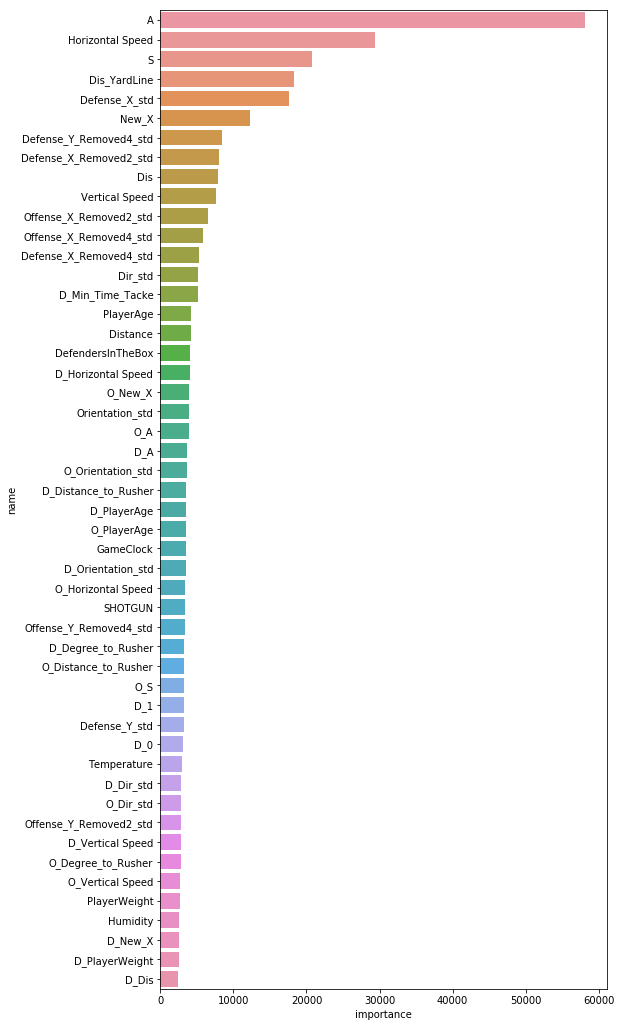

In [73]:
plt.figure(figsize = (8, 18))
sns.barplot(data = feature_importance_df.sort_values(by = "importance", ascending = False).head(50), x = "importance", y = "name")
plt.show()

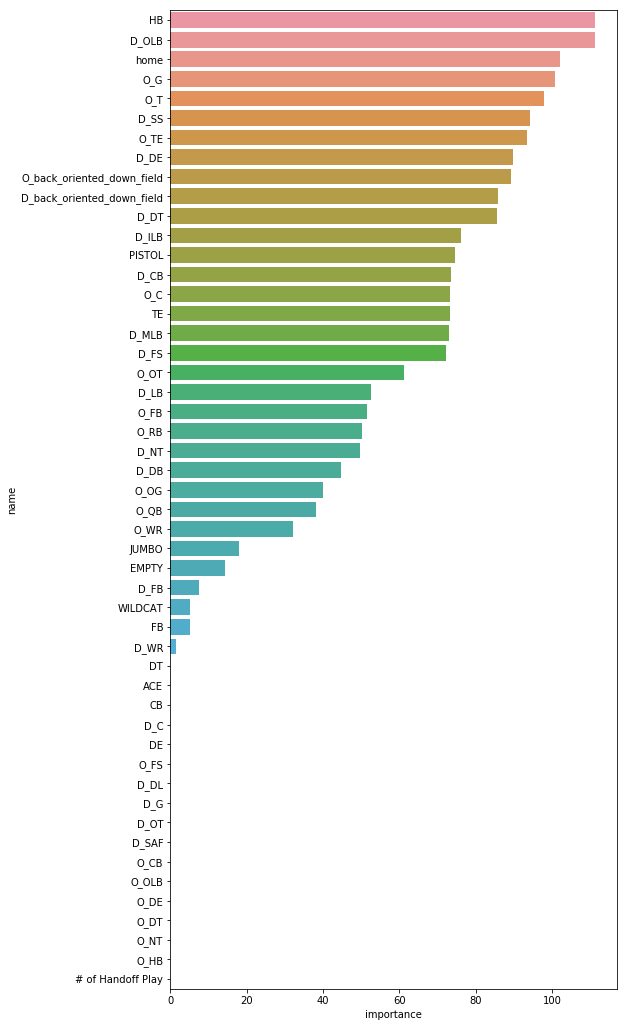

In [75]:
plt.figure(figsize = (8, 18))
sns.barplot(data = feature_importance_df.sort_values(by = "importance", ascending = False).tail(50), x = "importance", y = "name")
plt.show()